In [1]:
import wordgraph as wg
import os

from ggplot import *
import pandas as pd
from scipy import stats

In [2]:
G = wg.WordGraph()

In [3]:
def range_degree_merge_wb(graph_dir, wordbank_csv):
    wb_data = pd.read_csv(wordbank_csv)
    deg_dists = []
    
    for root, dirs, files in os.walk(graph_dir):
        for file in files:
            if not file.startswith("."):
                file = os.path.join(root, file)
                G.load_pickle(file)
                deg_dist = G.degree_distribution()
                deg_dist = pd.merge(deg_dist, wb_data, left_on='word', right_on='definition')
                deg_dists.append((G.epsilon, deg_dist))              
    return deg_dists

In [4]:
def kendall_dist_range(degree_dists):
    df = pd.DataFrame(columns=['epsilon', 'tau', 'p'])
    for pair in degree_dists:
        tau, p = stats.kendalltau(pair[1]['degree'], pair[1]['16'])
        entry = pd.DataFrame([[pair[0], tau, p]], columns=['epsilon', 'tau', 'p'])
        df = df.append(entry, ignore_index=True)
    return df

In [5]:
def spearman_dist_range(degree_dists):
    df = pd.DataFrame(columns=['epsilon', 'rho', 'p'])
    for pair in degree_dists:
        rho, p = stats.spearmanr(pair[1]['degree'], pair[1]['16'])
        entry = pd.DataFrame([[pair[0], rho, p]], columns=['epsilon', 'rho', 'p'])
        df = df.append(entry, ignore_index=True)
    return df

## Merge WordBank comprehension scores with SEEDLings degree distributions

In [11]:
degree_dists = range_degree_merge_wb(graph_dir='/Volumes/babylab_data/semspace_output/seedlings_all',
                                     wordbank_csv='data/wordbank_english.csv')

## Map correlation as a function of epsilon

In [12]:
kendall_df = kendall_dist_range(degree_dists)
spearman_df = spearman_dist_range(degree_dists)

max tau: 

epsilon    8.800000e-01
tau        3.144046e-01
p          9.525231e-17
Name: 68, dtype: float64


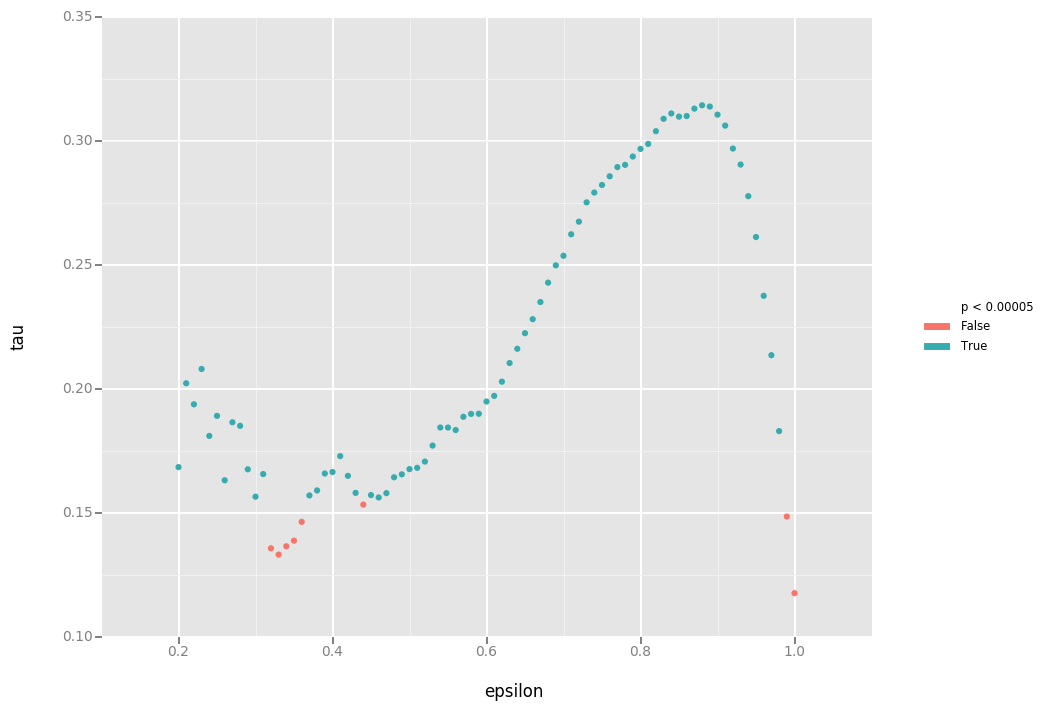

<ggplot: (287190883)>

In [13]:
print("max tau: \n\n{}".format(kendall_df.loc[kendall_df.tau.idxmax()]))

ggplot(kendall_df, aes(x='epsilon', y='tau', color='p < 0.00005'))+\
    geom_point()

max rho: 

epsilon    8.700000e-01
rho        4.493320e-01
p          5.219685e-17
Name: 67, dtype: float64


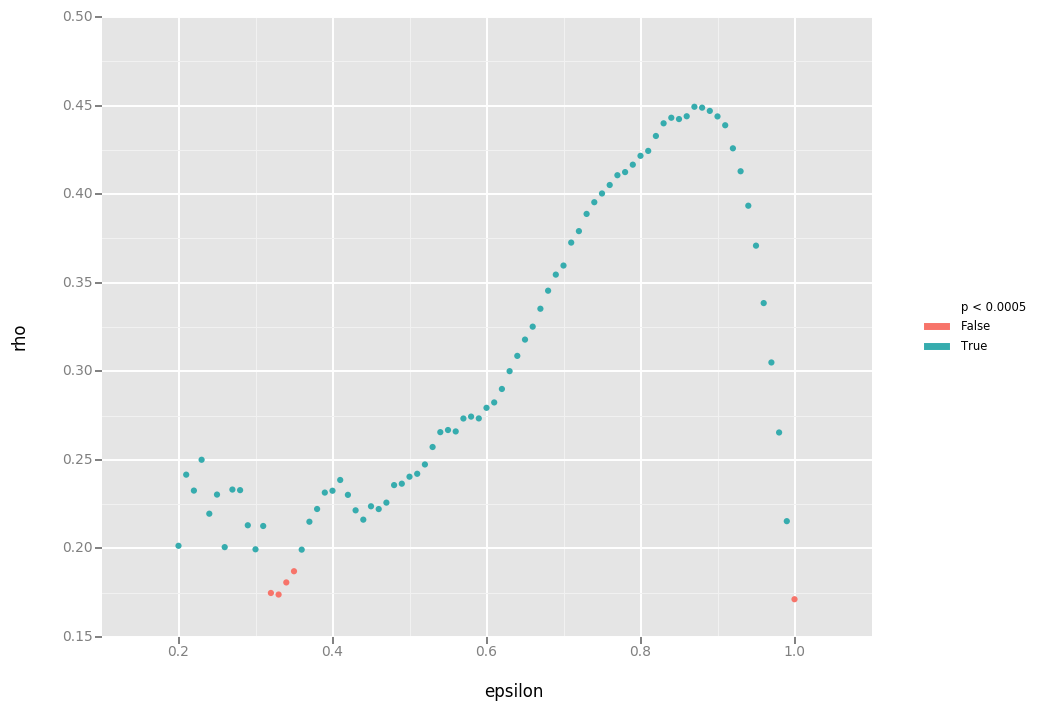

<ggplot: (283901644)>

In [14]:
print("max rho: \n\n{}".format(spearman_df.loc[spearman_df.rho.idxmax()]))

ggplot(spearman_df, aes(x='epsilon', y='rho', color='p < 0.0005'))+\
    geom_point()

## Generate degree distribution range for WordBank set

In [6]:
wb_degree_dist = range_degree_merge_wb(graph_dir='/Volumes/babylab_data/semspace_output/wordbank',
                                       wordbank_csv='data/wordbank_english.csv')

In [7]:
kendall_wb_df = kendall_dist_range(wb_degree_dist)

In [8]:
spearman_wb_df = spearman_dist_range(wb_degree_dist)

max tau: 

epsilon    8.800000e-01
tau        3.037089e-01
p          7.930427e-17
Name: 68, dtype: float64


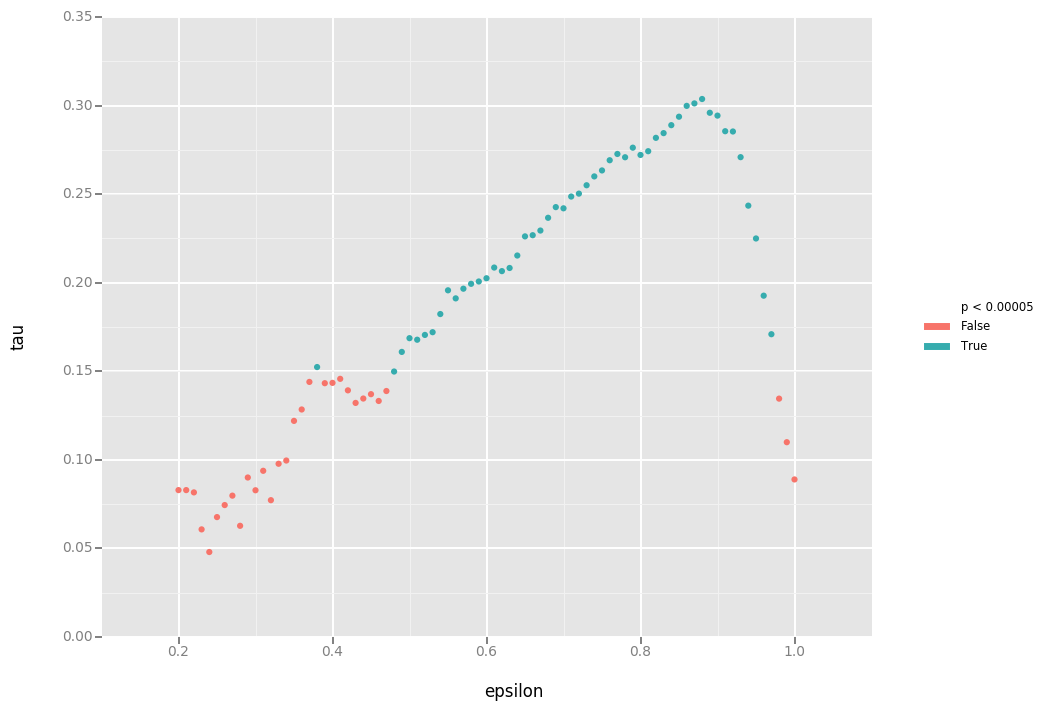

<ggplot: (287430222)>

In [9]:
print("max tau: \n\n{}".format(kendall_wb_df.loc[kendall_wb_df.tau.idxmax()]))

ggplot(kendall_wb_df, aes(x='epsilon', y='tau', color='p < 0.00005'))+\
    geom_point()

max rho: 

epsilon    8.700000e-01
rho        4.312261e-01
p          9.708213e-17
Name: 67, dtype: float64


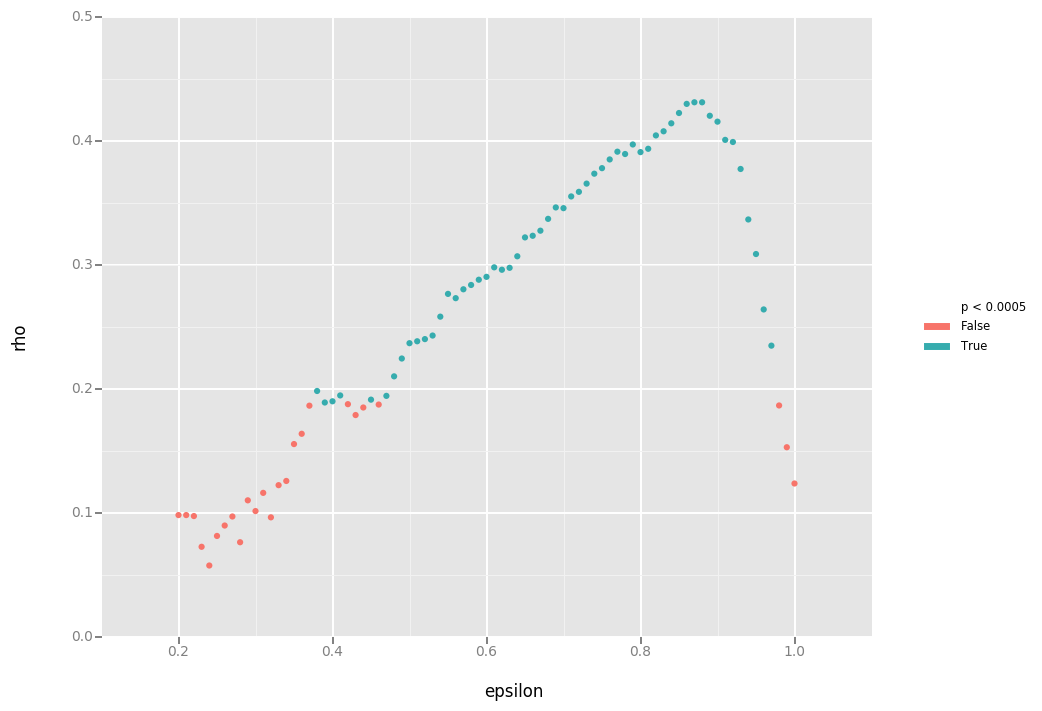

<ggplot: (-9223372036567345541)>

In [10]:
print("max rho: \n\n{}".format(spearman_wb_df.loc[spearman_wb_df.rho.idxmax()]))

ggplot(spearman_wb_df, aes(x='epsilon', y='rho', color='p < 0.0005'))+\
    geom_point()